In [0]:
!wget https://datahack-prod.s3.amazonaws.com/train_file/train_20D8GL3.csv

--2020-03-22 10:05:06--  https://datahack-prod.s3.amazonaws.com/train_file/train_20D8GL3.csv
Resolving datahack-prod.s3.amazonaws.com (datahack-prod.s3.amazonaws.com)... 52.219.64.124
Connecting to datahack-prod.s3.amazonaws.com (datahack-prod.s3.amazonaws.com)|52.219.64.124|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2006884 (1.9M) [text/csv]
Saving to: ‘train_20D8GL3.csv’

train_20D8GL3.csv   100%[===================>]   1.91M  1.11MB/s    in 1.7s    

2020-03-22 10:05:08 (1.11 MB/s) - ‘train_20D8GL3.csv’ saved [2006884/2006884]



In [0]:
!wget https://datahack-prod.s3.amazonaws.com/test_file/test_O6kKpvt.csv

--2020-03-22 10:05:11--  https://datahack-prod.s3.amazonaws.com/test_file/test_O6kKpvt.csv
Resolving datahack-prod.s3.amazonaws.com (datahack-prod.s3.amazonaws.com)... 52.219.62.32
Connecting to datahack-prod.s3.amazonaws.com (datahack-prod.s3.amazonaws.com)|52.219.62.32|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 842514 (823K) [text/csv]
Saving to: ‘test_O6kKpvt.csv’

test_O6kKpvt.csv    100%[===================>] 822.77K   673KB/s    in 1.2s    

2020-03-22 10:05:13 (673 KB/s) - ‘test_O6kKpvt.csv’ saved [842514/842514]



In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
train = pd.read_csv('train_20D8GL3.csv')
test = pd.read_csv('test_O6kKpvt.csv')

In [0]:
train.head(5)

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default_payment_next_month
0,25150,360000,2,2,2,25,-1,-1,-1,-1,-1,-1,20952,12590,3479,3435,8870,2020,12590,3479,3446,8870,2020,27043,0
1,13470,240000,2,1,2,46,2,2,-2,-1,0,-1,456,0,0,2240,1681,2267,0,0,2240,0,2267,3074,0
2,3092,320000,2,2,1,41,0,0,0,0,0,0,49846,53811,38717,35409,35036,35939,5000,2000,2000,3000,3000,1500,0
3,13973,50000,2,2,2,24,-1,-1,-2,-2,-2,-2,2675,0,0,0,0,0,0,0,0,0,0,0,1
4,10567,80000,1,3,1,52,-1,0,0,0,0,0,35861,18521,19385,20561,21261,21457,1500,1500,1500,1028,876,1449,0


In [0]:
test.head(5)

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,10178,60000,2,2,1,30,0,0,0,0,0,0,36082,37127,38117,38874,38667,39544,1628,1618,1375,1403,1520,1205
1,5304,200000,2,1,2,29,0,0,0,0,2,0,61099,64160,76593,93988,50292,10510,4160,14593,20150,0,5739,12050
2,5187,230000,1,1,2,39,0,0,0,0,-2,-2,38395,39943,20650,0,0,0,2500,2000,0,0,0,0
3,14495,150000,1,1,2,40,0,0,0,0,0,0,152175,148872,145978,139791,142745,146872,5800,5245,5200,5200,6500,7200
4,20444,140000,1,2,2,27,0,0,0,0,0,0,80210,67746,76230,77954,78953,81848,10000,10000,3393,3260,5000,3000


In [0]:
train['PAY_0'].unique()

array([-1,  2,  0, -2,  1,  3,  5,  4,  7,  6,  8])

In [0]:
train_df=train

In [0]:
train_df['default_payment_next_month'] = np.log1p(train_df['default_payment_next_month'])

In [0]:
X = train_df.drop(labels=['default_payment_next_month'], axis=1)
y = train_df['default_payment_next_month'].values

from sklearn.model_selection import train_test_split
X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size=0.25, random_state=1)

In [0]:
X_train.shape, y_train.shape, X_cv.shape, y_cv.shape

((15750, 24), (15750,), (5250, 24), (5250,))

In [0]:
from math import sqrt 
from sklearn.metrics import mean_squared_log_error

In [0]:
import lightgbm as lgb
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_cv, label=y_cv)

param = {'objective': 'regression',
         'boosting': 'gbdt',  
         'metric': 'l2_root',
         'learning_rate': 0.1, 
         'num_iterations': 3500,
         'num_leaves': 80,
         'max_depth': -1,
         'min_data_in_leaf': 11,
         'bagging_fraction': 0.80,
         'bagging_freq': 1,
         'bagging_seed': 3,
         'feature_fraction': 0.80,
         'feature_fraction_seed': 2,
         'early_stopping_round': 200,
         'max_bin': 250
         }

lgbm = lgb.train(params=param, verbose_eval=100, train_set=train_data, valid_sets=[test_data])

y_pred_lgbm = lgbm.predict(X_cv)
print('RMSLE:', sqrt(mean_squared_log_error(np.expm1(y_cv), np.expm1(y_pred_lgbm))))

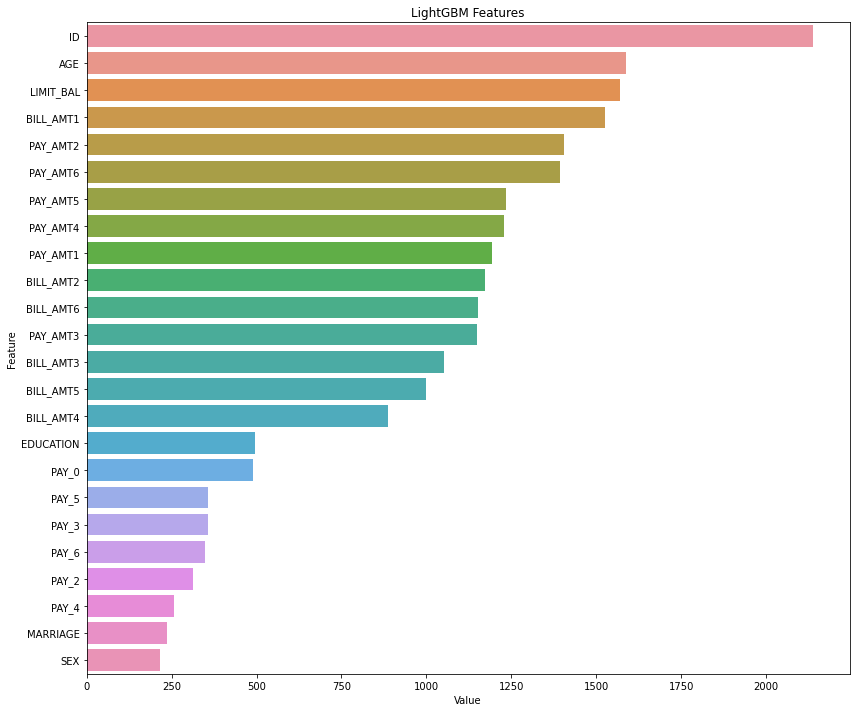

In [0]:
import seaborn as sns
feature_imp = pd.DataFrame(sorted(zip(lgbm.feature_importance(), X.columns), reverse=True)[:50], 
                           columns=['Value','Feature'])
plt.figure(figsize=(12, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()

In [0]:

Xtest = test

In [0]:

from sklearn.model_selection import KFold
from lightgbm import LGBMRegressor

errlgb = []
y_pred_totlgb = []

fold = KFold(n_splits=15, shuffle=True, random_state=42)

for train_index, test_index in fold.split(X):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    lgbm = LGBMRegressor(**param)
    lgbm.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=0, early_stopping_rounds=200)

    y_pred_lgbm = lgbm.predict(X_test)
    print("RMSLE LGBM: ", sqrt(mean_squared_log_error(np.exp(y_test), np.exp(y_pred_lgbm))))

    errlgb.append(sqrt(mean_squared_log_error(np.exp(y_test), np.exp(y_pred_lgbm))))
    p = lgbm.predict(Xtest)
    y_pred_totlgb.append(p)

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


RMSLE LGBM:  0.15001632571927273


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


RMSLE LGBM:  0.15073571113646125


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


RMSLE LGBM:  0.15337177154138984


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


RMSLE LGBM:  0.14973119336987784


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


RMSLE LGBM:  0.14382082615260292


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


RMSLE LGBM:  0.14732859034139462


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


RMSLE LGBM:  0.14671143641728984


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


RMSLE LGBM:  0.14788362604564667


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


RMSLE LGBM:  0.14627653540248428


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


RMSLE LGBM:  0.14930758813367145


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


RMSLE LGBM:  0.1473109230546469


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


RMSLE LGBM:  0.14935250314211704


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


RMSLE LGBM:  0.14597618125398895


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


RMSLE LGBM:  0.14806180939358332


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


RMSLE LGBM:  0.1477843439503432


In [0]:

np.mean(errlgb,0)

0.1482446243369847

In [0]:
lgbm_final = np.expm1(np.mean(y_pred_totlgb,0))
lgbm_final

array([0.11928961, 0.09795289, 0.07795641, ..., 0.09543715, 0.08781526,
       0.20513766])

In [0]:
df_sub = pd.DataFrame(data=lgbm_final, columns=['default_payment_next_month'])
df_sub.head()

,default_payment_next_month
0,0.119290
1,0.097953
2,0.077956
3,0.058688
4,0.054072


In [0]:
train.dtypes,test.dtypes

(ID                            int64
 LIMIT_BAL                     int64
 SEX                           int64
 EDUCATION                     int64
 MARRIAGE                      int64
 AGE                           int64
 PAY_0                         int64
 PAY_2                         int64
 PAY_3                         int64
 PAY_4                         int64
 PAY_5                         int64
 PAY_6                         int64
 BILL_AMT1                     int64
 BILL_AMT2                     int64
 BILL_AMT3                     int64
 BILL_AMT4                     int64
 BILL_AMT5                     int64
 BILL_AMT6                     int64
 PAY_AMT1                      int64
 PAY_AMT2                      int64
 PAY_AMT3                      int64
 PAY_AMT4                      int64
 PAY_AMT5                      int64
 PAY_AMT6                      int64
 default_payment_next_month    int64
 dtype: object, ID           int64
 LIMIT_BAL    int64
 SEX          int64


In [0]:
train.duplicated().sum(), test.duplicated().sum()

(0, 0)

In [0]:
train.describe()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default_payment_next_month
count,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.00000,21000.000000,21000.000000,21000.00000,21000.000000,21000.000000,21000.000000,21000.000000,2.100000e+04,21000.000000,21000.000000,21000.000000,21000.000000,2.100000e+04,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000
mean,14949.183667,167214.746667,1.607571,1.854190,1.551714,35.461619,-0.01119,-0.127238,-0.164857,-0.21819,-0.260952,-0.288667,51501.542381,49463.502667,4.723258e+04,43387.372476,40398.551095,38931.194000,5686.349333,5.923003e+03,5202.325333,4793.172000,4797.012952,5211.736762,0.221190
std,8632.775153,128965.188482,0.488303,0.791628,0.521176,9.206628,1.12321,1.198957,1.198624,1.17221,1.141454,1.151592,73453.641859,70866.586004,6.953988e+04,64081.073110,60396.811177,59196.499234,16868.075695,2.390953e+04,17006.416467,15467.403159,15270.031988,17698.795697,0.415058
min,1.000000,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.00000,-2.000000,-2.000000,-2.00000,-2.000000,-2.000000,-14386.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-209051.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7508.750000,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.00000,-1.000000,-1.000000,-1.00000,-1.000000,-1.000000,3564.750000,3000.000000,2.686250e+03,2332.000000,1759.000000,1242.750000,998.250000,8.360000e+02,390.000000,284.000000,241.000000,102.000000,0.000000
50%,14939.500000,140000.000000,2.000000,2.000000,2.000000,34.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,22578.000000,21550.000000,2.024200e+04,19158.500000,18266.500000,17203.500000,2100.000000,2.011000e+03,1811.500000,1500.000000,1500.000000,1500.000000,0.000000
75%,22386.750000,240000.000000,2.000000,2.000000,2.000000,41.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,67876.250000,64918.250000,6.082675e+04,55376.750000,50517.250000,49463.000000,5023.250000,5.000000e+03,4500.000000,4002.250000,4051.000000,4000.000000,0.000000
max,29998.000000,800000.000000,2.000000,6.000000,3.000000,75.000000,8.00000,8.000000,8.000000,8.00000,8.000000,8.000000,746814.000000,743970.000000,1.664089e+06,706864.000000,587067.000000,699944.000000,873552.000000,1.684259e+06,889043.000000,621000.000000,417990.000000,528666.000000,1.000000


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import matplotlib as mpl

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from sklearn.ensemble import ExtraTreesClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold, learning_curve, ShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import VotingClassifier, IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import confusion_matrix

In [0]:
X = train.drop(columns=['ID', 'default_payment_next_month'])
y = train.default_payment_next_month

In [0]:
print('Percentage of each class in Target Variable \n')
print((train.default_payment_next_month.value_counts()/len(train))*100)

Percentage of each class in Target Variable 

0    77.880952
1    22.119048
Name: default_payment_next_month, dtype: float64


In [0]:
rfc = RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42, max_features=0.7 , bootstrap=False)
cross_val_score(rfc, X, y, cv=5, n_jobs=-1, verbose=1, scoring='f1_weighted').mean()

In [0]:
y = train.default_payment_next_month
corr = pd.concat(objs=[X, y], axis=1).corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(5)

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default_payment_next_month
LIMIT_BAL,1,0.029683,-0.21676,-0.11045,0.14321,-0.27206,-0.29732,-0.29006,-0.26965,-0.2534,-0.2356,0.29054,0.28365,0.28895,0.29745,0.29738,0.29152,0.195,0.17659,0.20664,0.19947,0.22132,0.21507,-0.15916
SEX,0.029683,1,0.011012,-0.03393,-0.092907,-0.061232,-0.072602,-0.064406,-0.061242,-0.05592,-0.045045,-0.031595,-0.030287,-0.023328,-0.01743,-0.014278,-0.013546,0.0039069,0.00039755,-0.0039197,4.2392e-05,0.002165,0.0037595,-0.037634
EDUCATION,-0.21676,0.011012,1,-0.14309,0.17225,0.10582,0.11913,0.11022,0.10361,0.094702,0.080033,0.027826,0.022834,0.015698,0.0023176,-0.0052428,-0.006436,-0.042164,-0.032573,-0.045854,-0.04162,-0.03562,-0.031098,0.021347
MARRIAGE,-0.11045,-0.03393,-0.14309,1,-0.41424,0.02942,0.032403,0.043988,0.042245,0.044779,0.043123,-0.026133,-0.023962,-0.027713,-0.024648,-0.026143,-0.02093,-0.0022269,-0.0066335,1.8013e-05,-0.014061,-0.0033753,-0.0055549,-0.016888
AGE,0.14321,-0.092907,0.17225,-0.41424,1,-0.043313,-0.05509,-0.058891,-0.057324,-0.061018,-0.050668,0.054186,0.053819,0.053439,0.049968,0.048377,0.047465,0.025439,0.022501,0.025842,0.026427,0.024296,0.016846,0.0066645
PAY_0,-0.27206,-0.061232,0.10582,0.02942,-0.043313,1,0.66916,0.57342,0.5409,0.50696,0.47255,0.18312,0.18433,0.17363,0.17513,0.17681,0.17214,-0.08534,-0.070403,-0.079509,-0.06583,-0.061725,-0.065042,0.32585
PAY_2,-0.29732,-0.072602,0.11913,0.032403,-0.05509,0.66916,1,0.76804,0.66206,0.62177,0.57346,0.23025,0.2294,0.21719,0.21811,0.2174,0.21507,-0.083156,-0.060032,-0.064262,-0.051836,-0.04199,-0.042252,0.26355
PAY_3,-0.29006,-0.064406,0.11022,0.043988,-0.058891,0.57342,0.76804,1,0.78038,0.69284,0.636,0.2056,0.23315,0.22287,0.22417,0.2226,0.22017,-0.0044581,-0.063249,-0.058944,-0.050562,-0.034179,-0.03905,0.23593
PAY_4,-0.26965,-0.061242,0.10361,0.042245,-0.057324,0.5409,0.66206,0.78038,1,0.82604,0.72024,0.19907,0.2226,0.24068,0.2425,0.24013,0.23639,-0.01407,-0.0016155,-0.073125,-0.04696,-0.032112,-0.031699,0.22008
PAY_5,-0.2534,-0.05592,0.094702,0.044779,-0.061018,0.50696,0.62177,0.69284,0.82604,1,0.81792,0.19802,0.21924,0.23559,0.26727,0.26572,0.25821,-0.0090257,-0.0032001,0.0050192,-0.060878,-0.032454,-0.027342,0.20878


In [0]:
X_test = test.drop(columns=['ID'])
concat = pd.concat(objs=[X, X_test], axis=0)

In [0]:
concat.drop(columns=['PAY_AMT6','PAY_AMT5','SEX'
                     ], inplace=True)

ss = StandardScaler()
concat = ss.fit_transform(concat)

X, X_test = concat[:len(train), :], concat[len(train):, :]

In [0]:
rfc = RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42, max_features=0.7 , bootstrap=False)
cross_val_score(rfc, X, y, cv=5, n_jobs=-1, verbose=1, scoring='f1_weighted').mean()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.0min finished


0.7836981205801333

In [0]:
nnc = MLPClassifier(hidden_layer_sizes=(10,5), max_iter=300,activation = 'relu',solver='adam', 
                           random_state=1, batch_size=50)
cross_val_score(nnc, X, y, cv=5, n_jobs=-1, verbose=1, scoring='f1_weighted').mean()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.3min finished


0.7985018172686852

In [0]:
lgbmc = LGBMClassifier(random_state=2, n_estimators=100, colsample_bytree=0.3, 
                       max_depth=3, learning_rate=0.09, boosting_type='gbdt')
cross_val_score(lgbmc, X, y, cv=5, n_jobs=-1, verbose=1, scoring='f1_weighted').mean()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s finished


0.7999428482422921

In [0]:
xgbc = XGBClassifier(seed=7, n_jobs=-1, n_estimators=100, random_state=0, max_depth=7, learning_rate=0.1)
cross_val_score(xgbc, X, y, cv=5, n_jobs=-1, verbose=1, scoring='f1_weighted').mean()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   14.7s finished


0.7976726693514212

In [0]:
lgbmc.fit(X, y)
j = lgbmc.predict(X_test)
sub = pd.DataFrame(data={'ID' : test.ID, 'default_payment_next_month' : j})
sub.to_csv('C1.csv', index=False)

In [0]:
from google.colab import files
files.download('C1.csv')

In [0]:
train_df=train
test_df=test

In [0]:
X = train_df.drop(labels=['default_payment_next_month'], axis=1)
y = train_df['default_payment_next_month'].values

from sklearn.model_selection import train_test_split
X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size=0.25, random_state=1)

In [0]:
categorical_features_indices = np.where(X_train.dtypes == 'category')[0]
categorical_features_indices

array([], dtype=int64)

In [0]:
from math import sqrt 
from sklearn.metrics import accuracy_score

In [0]:
!pip install catboost
from catboost import CatBoostClassifier
cat = CatBoostClassifier(loss_function='MultiClass', 
                         eval_metric='Accuracy', 
                         depth=7,
                         random_seed=42, 
                         iterations=1000, 
                         learning_rate=0.1,
                         leaf_estimation_iterations=1,
                         l2_leaf_reg=1,
                         bootstrap_type='Bayesian', 
                         bagging_temperature=1, 
                         random_strength=1,
                         od_type='Iter', 
                         od_wait=200)
cat.fit(X_train, y_train, verbose=50,
        use_best_model=True,
        cat_features=categorical_features_indices,
        eval_set=[(X_train, y_train),(X_cv, y_cv)],
        plot=False)

     |████████████████████████████████| 64.4MB 67kB/s 
0:	learn: 0.8214603	test: 0.8214603	test1: 0.8196190	best: 0.8196190 (0)	total: 71.8ms	remaining: 1m 11s
50:	learn: 0.8306032	test: 0.8306032	test1: 0.8234286	best: 0.8243810 (43)	total: 1.07s	remaining: 19.9s
100:	learn: 0.8386032	test: 0.8386032	test1: 0.8232381	best: 0.8243810 (43)	total: 2.05s	remaining: 18.3s
150:	learn: 0.8456508	test: 0.8456508	test1: 0.8220952	best: 0.8243810 (43)	total: 3.03s	remaining: 17s
200:	learn: 0.8539683	test: 0.8539683	test1: 0.8209524	best: 0.8243810 (43)	total: 4.01s	remaining: 16s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.8243809524
bestIteration = 43

Shrink model to first 44 iterations.


In [0]:
predictions = cat.predict(X_cv)
print('accuracy:', accuracy_score(y_cv, predictions))

accuracy: 0.8243809523809524


In [0]:
import seaborn as sns

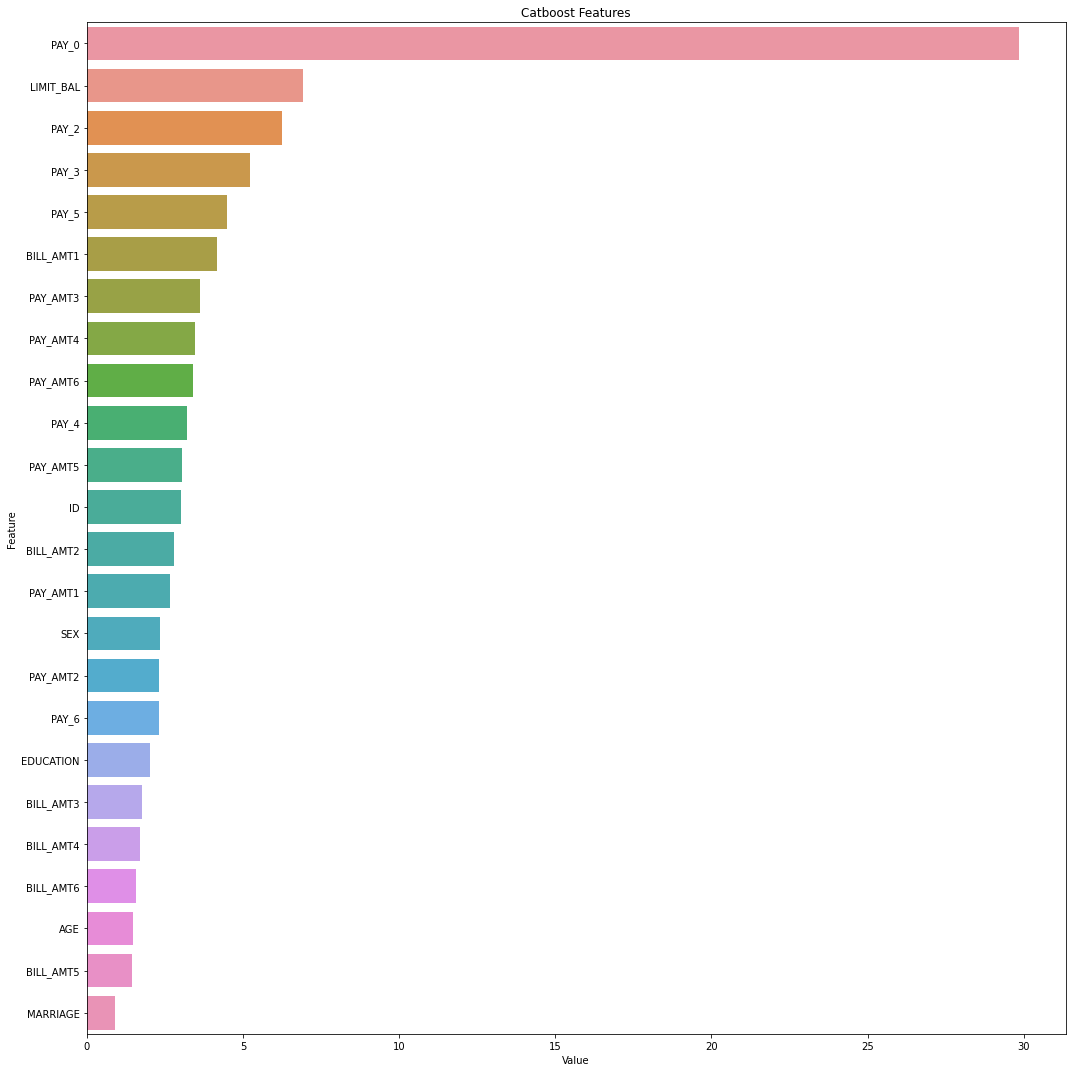

In [0]:
feature_imp = pd.DataFrame(sorted(zip(cat.feature_importances_, X.columns), reverse=True)[:50], 
                           columns=['Value','Feature'])
plt.figure(figsize=(15,15))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('Catboost Features')
plt.tight_layout()
plt.show()

In [0]:
Xtest = test_df

In [0]:
from sklearn.model_selection import KFold

errcat = []
y_pred_totcat = []

fold = KFold(n_splits=15, shuffle=True, random_state=42)

for train_index, test_index in fold.split(X):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    cat = CatBoostClassifier(loss_function='MultiClass', 
                         eval_metric='Accuracy', 
                         depth=6,
                         random_seed=42, 
                         iterations=1000, 
                         learning_rate=0.07,
                         leaf_estimation_iterations=1,
                         l2_leaf_reg=1, 
                         bootstrap_type='Bayesian', 
                         bagging_temperature=1, 
                         random_strength=1,
                         od_type='Iter', 
                         od_wait=200)
    cat.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=0, early_stopping_rounds=200, cat_features=categorical_features_indices)

    y_pred_cat = cat.predict(X_test)
    print("Accuracy: ", accuracy_score(y_test,y_pred_cat))

    errcat.append(accuracy_score(y_test,y_pred_cat))
    p = cat.predict(Xtest)
    y_pred_totcat.append(p)

Accuracy:  0.82
Accuracy:  0.8192857142857143
Accuracy:  0.8107142857142857
Accuracy:  0.8207142857142857
Accuracy:  0.8421428571428572
Accuracy:  0.835
Accuracy:  0.8271428571428572
Accuracy:  0.8271428571428572
Accuracy:  0.8228571428571428
Accuracy:  0.825
Accuracy:  0.8292857142857143
Accuracy:  0.8278571428571428
Accuracy:  0.8278571428571428
Accuracy:  0.8257142857142857
Accuracy:  0.8264285714285714


In [0]:
np.mean(errcat,0)

0.8258095238095238

In [0]:
cat_final = np.mean(y_pred_totcat,0).round().astype(int)
cat_final

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

In [0]:
#y_pred_class = le.inverse_transform(cat_final)
df_sub = pd.DataFrame(data=cat_final, columns=['default_payment_next_month'])
df_sub.head()

,default_payment_next_month
0,0
1,0
2,0
3,0
4,0


In [0]:
df_sub['default_payment_next_month'].value_counts()

0.121755    1
0.084629    1
0.130620    1
0.135476    1
0.068278    1
           ..
0.028972    1
0.148566    1
0.273128    1
0.093741    1
0.083921    1
Name: default_payment_next_month, Length: 9000, dtype: int64

In [0]:
!pip install xlsxwriter
writer = pd.ExcelWriter('cat40.xlsx', engine='xlsxwriter')
df_sub.to_excel(writer,sheet_name='Sheet1', index=False)
writer.save()

     |████████████████████████████████| 143kB 2.9MB/s 


In [0]:
from google.colab import files
files.download('cat40.xlsx')

In [0]:
from sklearn import preprocessing
from sklearn.preprocessing import normalize

X_train = train.drop("default_payment_next_month", axis=1)
X_train = X_train.drop("ID", axis=1)
Y_train = train["default_payment_next_month"].values
X_test = test.drop("ID", axis=1)

min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(X_train)
X_train = pd.DataFrame(np_scaled)

min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(X_test)
X_test = pd.DataFrame(np_scaled)

In [0]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

In [0]:
X_train.shape, Y_train.shape, X_test.shape

((21000, 23), (21000,), (9000, 23))

In [0]:
#Support Vector Machines (SVM)
svc = SVC()
svc.fit(X_train, Y_train)
Y_pred = svc.predict(X_test)
acc_svc = round(svc.score(X_train, Y_train) * 100, 2)
acc_svc

81.91

In [0]:
#K-nearest (k-NN)
knn = KNeighborsClassifier(n_neighbors = 4)
knn.fit(X_train, Y_train)
Y_pred = knn.predict(X_test)
acc_knn = round(knn.score(X_train, Y_train) * 100, 20)
acc_knn

84.28095238095239

In [0]:
#Perceptron
perceptron = Perceptron()
perceptron.fit(X_train, Y_train)
Y_pred = perceptron.predict(X_test)
acc_perceptron = round(perceptron.score(X_train, Y_train) * 100, 2)
acc_perceptron

79.41

In [0]:
# Linear SVC

linear_svc = LinearSVC()
linear_svc.fit(X_train, Y_train)
Y_pred = linear_svc.predict(X_test)
acc_linear_svc = round(linear_svc.score(X_train, Y_train) * 100, 4)
acc_linear_svc

80.1524

In [0]:
# Stochastic Gradient Descent

sgd = SGDClassifier()
sgd.fit(X_train, Y_train)
Y_pred = sgd.predict(X_test)
acc_sgd = round(sgd.score(X_train, Y_train) * 100, 2)
acc_sgd

80.47

In [0]:
# Decision Tree

decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)
Y_pred = decision_tree.predict(X_test)
acc_decision_tree = round(decision_tree.score(X_train, Y_train) * 100, 2)
acc_decision_tree

99.95

In [0]:
# Random Forest

random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)
Y_pred = random_forest.predict(X_test)
random_forest.score(X_train, Y_train)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 0)
acc_random_forest

100.0

In [0]:
submission = pd.DataFrame({
        "ID": test["ID"],
        "default_payment_next_month": Y_pred
    })
submission.to_csv('./submission.csv', index=False)
print(submission)

         ID  default_payment_next_month
0     10178                           0
1      5304                           0
2      5187                           0
3     14495                           0
4     20444                           0
...     ...                         ...
8995  16413                           0
8996  17210                           0
8997  24002                           1
8998  17019                           0
8999  23415                           0

[9000 rows x 2 columns]


In [0]:
from google.colab import files
files.download('submission.csv')